In [1]:
import os
try:
	os.chdir(os.path.join(os.getcwd(), 'dissertation_amod'))
	print(os.getcwd())
except:
	pass

/home/nick/src/jaratest/nick/analysis/dissertation_amod


 ## Figure - single sound types

In [2]:
import os
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from jaratoolbox import settings
from jaratoolbox import extraplots
from jaratoolbox import extrastats



In [3]:
dataDir = '/home/nick/data/dissertation_amod/'

subjectsToPlot = [('amod006', 'tones'), 
                  ('amod007', 'tones'),
                  ('amod008', 'tones'),
                  ('amod009', 'tones')]

# subject = 'amod001'
# stype = 'am'

SAVE = 0

plt.clf()


musFilename = '{}_psychometric_{}_muscimol.npz'.format(stype, subject)
musFullPath = os.path.join(dataDir,musFilename)
musData = np.load(musFullPath)

salFilename = '{}_psychometric_{}_saline.npz'.format(stype, subject)
salFullPath = os.path.join(dataDir,salFilename)
salData = np.load(salFullPath)

dataToPlot = [musData, salData]
curveColors = ['r', 'k']
plotHandles = []

fontSizeLabels = 12
fontSizeTicks = 12
fontSizePanel = 16

ax1 = plt.subplot(111)

for indCond, condData in enumerate(dataToPlot):

    color = curveColors[indCond]

    logPossibleValues = condData['logPossibleValues']
    estimate = condData['estimate']
    ciHitsEachValue = condData['ciHitsEachValue']
    fractionHitsEachValue = condData['fractionHitsEachValue']
    possibleValues = condData['possibleValues']

    xRange = logPossibleValues[-1]-logPossibleValues[1]

    fitxvals = np.linspace(logPossibleValues[0]-0.1*xRange,logPossibleValues[-1]+0.1*xRange,40)
    fityvals = extrastats.psychfun(fitxvals, *estimate)

    upperWhisker = ciHitsEachValue[1,:]-fractionHitsEachValue
    lowerWhisker = fractionHitsEachValue-ciHitsEachValue[0,:]

    # ax1.hold(True)
    (pline, pcaps, pbars) = ax1.errorbar(logPossibleValues,
                                            100*fractionHitsEachValue,
                                            yerr = [100*lowerWhisker, 100*upperWhisker],
                                            ecolor=color, fmt=None, clip_on=False)

    pdots = ax1.plot(logPossibleValues, 100*fractionHitsEachValue, 'o', ms=6, mec='None', mfc=color,
                        clip_on=False)

    #ax1.set_xticks(logPossibleValues)
    #freqLabels = ['{:.03}'.format(x) for x in possibleValues/1000.0]
    #ax1.set_xticklabels(freqLabels)
    #ax1.set_xlabel('Frequency (kHz)', fontsize=fontSizeLabels)

    pfit, = ax1.plot(fitxvals, 100*fityvals, color=color, lw=2, clip_on=False)
    plotHandles.append(pfit)

# ax1.annotate('B', xy=(labelPosX[0],labelPosY[0]), xycoords='axes fraction',
#                 fontsize=fontSizePanel, fontweight='bold')

extraplots.boxoff(ax1)

xticks = ax1.get_xticks()
newXtickLabels = np.logspace(logPossibleValues[0], logPossibleValues[-1], 3, base=2)
# 1/0
ax1.set_xticks(np.log2(np.array(newXtickLabels)))
if not stype=='amp_mod':
    ax1.set_xticklabels(['{:.3}'.format(x/1000.0) for x in newXtickLabels])
    ax1.set_xlabel('Frequency (kHz)', fontsize=fontSizeLabels)
    ax1.set_title(stype.capitalize())
else:
    ax1.set_xticklabels(['{:.3}'.format(x) for x in newXtickLabels])
    ax1.set_xlabel('AM Rate (Hz)', fontsize=fontSizeLabels)
    ax1.set_title("AM")

# ax1.set_xlim([fitxvals[0],fitxvals[-1]])

ax1.set_ylim([0, 100])
ax1.set_ylabel('Rightward trials (%)', fontsize=fontSizeLabels)
extraplots.set_ticks_fontsize(plt.gca(),fontSizeTicks)
ax1.set_yticks([0, 50, 100])

leg = ax1.legend([plotHandles[1],plotHandles[0]],
                 ['Saline','Muscimol'], loc='upper left', frameon=False,
                 labelspacing=0.1, handlelength=1.5, handletextpad=0.2,
                 borderaxespad=0.1, fontsize=12) 
plt.show()

if SAVE:
    fig = plt.gcf()
    fig.set_size_inches(4, 4)
    plt.tight_layout()
    saveDir = '/home/nick/data/dissertation_amod/'
    plt.savefig(os.path.join(saveDir, 'figure_{}_single_sound_type.png'.format(subject)))


NameError: name 'stype' is not defined

 ## Calculating percent correct

 To get percent correct I need to go back to the code that generates the intermediate data

In [4]:
from jaratoolbox import loadbehavior

# Frequency first
# Muscimol injected at 1mg/ml. We used lower concentrations after this.
sessions = {'amod006':['20161003a', '20161004a'],
            'amod007':['20161003a', '20161004a'],
            'amod008':['20161003a', '20161004a'],
            'amod009':['20161003a', '20161004a']}

muscimol = {'amod006':[0, 1],
            'amod007':[0, 1],
            'amod008':[0, 1],
            'amod009':[0, 1]}

salineSessions = {animal: [session for session,
                           mus in zip(sessions[animal],
                                      muscimol[animal]) if mus==0]
                  for animal in sessions.keys()}
muscimolSessions = {animal: [session for session,
                             mus in zip(sessions[animal],
                                        muscimol[animal]) if mus==1]
                    for animal in sessions.keys()}



In [5]:
subjects = sessions.keys()

numCorrectSaline = {}
numValidSaline = {}

for subject in subjects:
    allSessions = salineSessions[subject]
    allValid = np.empty(len(allSessions))
    allCorrect = np.empty(len(allSessions))
    for indSession, session in enumerate(allSessions):
        bfile = loadbehavior.path_to_behavior_data(subject, '2afc', session)
        bdata = loadbehavior.BehaviorData(bfile)

        valid = bdata['valid']
        correct = bdata['outcome'] == bdata.labels['outcome']['correct']
        validCorrect = (valid & correct)
        allValid[indSession] = sum(valid)
        allCorrect[indSession] = sum(validCorrect)
    numValidSaline[subject] = allValid
    numCorrectSaline[subject] = allCorrect
#percCorrect[indSubject, indSession] = (numCorrect/float(numValid))*100



In [6]:
numCorrectMuscimol = {}
numValidMuscimol = {}

for subject in subjects:
    allSessions = muscimolSessions[subject]
    allValid = np.empty(len(allSessions))
    allCorrect = np.empty(len(allSessions))
    for indSession, session in enumerate(allSessions):
        bfile = loadbehavior.path_to_behavior_data(subject, '2afc', session)
        bdata = loadbehavior.BehaviorData(bfile)

        valid = bdata['valid']
        correct = bdata['outcome'] == bdata.labels['outcome']['correct']
        validCorrect = (valid & correct)
        allValid[indSession] = sum(valid)
        allCorrect[indSession] = sum(validCorrect)
    numValidMuscimol[subject] = allValid
    numCorrectMuscimol[subject] = allCorrect


 ## Plot percent correct for muscimol and saline conditions

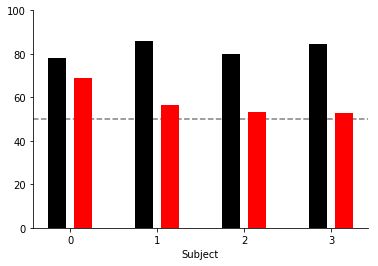

In [7]:
from jaratoolbox import extraplots

muscimolColor = 'r'
salineColor = 'k'
width = 0.2
condOffset = 0.15
ax = plt.subplot(111)
for indSubject, subject in enumerate(subjects):
    ax.bar(indSubject-condOffset,
            100*np.mean(numCorrectSaline[subject]/numValidSaline[subject]),
           width=width,
           color=salineColor)
    ax.bar(indSubject+condOffset,
            100*np.mean(numCorrectMuscimol[subject]/numValidMuscimol[subject]),
           width=width,
           color=muscimolColor)
    
ax.set_xticks(range(4))
ax.set_xlabel('Subject')

ax.set_ylim([0, 100])
ax.axhline(y=50, color='0.5', ls='--', zorder=-1)
extraplots.boxoff(ax)


 #### Discrimination of sound frequency is affected by muscimol inactivation of AC during single-sound-type sessions

In [8]:
# Muscimol injected at 1mg/ml. We used lower concentrations after this.
sessions = {'amod001':['20160316a', '20160317a', '20160318a', '20160319a',
                       '20160320a', '20160321a', '20160322a', '20160323a'],
            'amod005':['20160316a', '20160317a', '20160318a', '20160319a',
                       '20160320a', '20160321a', '20160322a', '20160323a']}
muscimol = {'amod001':[0, 1, 0, 1, 0, 1, 0, 1],
            'amod005':[0, 1, 0, 1, 0, 1, 0, 1]}

salineSessions = {animal: [session for session,
                           mus in zip(sessions[animal],
                                      muscimol[animal]) if mus==0]
                  for animal in sessions.keys()}
muscimolSessions = {animal: [session for session,
                             mus in zip(sessions[animal],
                                        muscimol[animal]) if mus==1]
                    for animal in sessions.keys()}



In [9]:
subjects = sessions.keys()

numCorrectSaline = {}
numValidSaline = {}

for subject in subjects:
    allSessions = salineSessions[subject]
    allValid = np.empty(len(allSessions))
    allCorrect = np.empty(len(allSessions))
    for indSession, session in enumerate(allSessions):
        bfile = loadbehavior.path_to_behavior_data(subject, '2afc', session)
        bdata = loadbehavior.BehaviorData(bfile)

        valid = bdata['valid']
        correct = bdata['outcome'] == bdata.labels['outcome']['correct']
        validCorrect = (valid & correct)
        allValid[indSession] = sum(valid)
        allCorrect[indSession] = sum(validCorrect)
    numValidSaline[subject] = allValid
    numCorrectSaline[subject] = allCorrect
#percCorrect[indSubject, indSession] = (numCorrect/float(numValid))*100



In [10]:
numCorrectMuscimol = {}
numValidMuscimol = {}

for subject in subjects:
    allSessions = muscimolSessions[subject]
    allValid = np.empty(len(allSessions))
    allCorrect = np.empty(len(allSessions))
    for indSession, session in enumerate(allSessions):
        bfile = loadbehavior.path_to_behavior_data(subject, '2afc', session)
        bdata = loadbehavior.BehaviorData(bfile)

        valid = bdata['valid']
        correct = bdata['outcome'] == bdata.labels['outcome']['correct']
        validCorrect = (valid & correct)
        allValid[indSession] = sum(valid)
        allCorrect[indSession] = sum(validCorrect)
    numValidMuscimol[subject] = allValid
    numCorrectMuscimol[subject] = allCorrect


 ## Plot percent correct for muscimol and saline conditions, AM

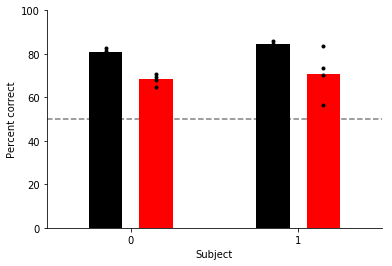

In [11]:
from jaratoolbox import extraplots

muscimolColor = 'r'
salineColor = 'k'
width = 0.2
condOffset = 0.15
ax = plt.subplot(111)
for indSubject, subject in enumerate(subjects):
    pcSal = 100*numCorrectSaline[subject]/numValidSaline[subject],
    ax.plot((np.ones(len(pcSal))*indSubject) - condOffset,
           pcSal, 'k.')
    ax.bar(indSubject-condOffset,
           np.mean(pcSal), 
           width=width,
           color=salineColor)
    pcMus = 100*numCorrectMuscimol[subject]/numValidMuscimol[subject],
    ax.plot((np.ones(len(pcMus))*indSubject) + condOffset,
           pcMus, 'k.')
    ax.bar(indSubject+condOffset,
           np.mean(pcMus),
           width=width,
           color=muscimolColor)
    
ax.set_xticks(range(len(subjects)))
ax.set_xlabel('Subject')

ax.set_ylim([0, 100])
ax.axhline(y=50, color='0.5', ls='--', zorder=-1)
ax.set_xlim([-0.5, 1.5])
ax.set_ylabel('Percent correct')
extraplots.boxoff(ax)


 ### Put it all together
 I want to show it like this: Panel A, Tones psycurve. B: tones summary. C: AM psycurve, D: AM summary.